In [50]:
%matplotlib inline

import matplotlib
# matplotlib.use('pgf')
pgf_with_rc_fonts = {
    "font.family": "serif",
    "font.serif": [],                   # use latex default serif font
    "font.sans-serif": ["DejaVu Sans"], # use a specific sans-serif font
    "pgf.rcfonts" : False
}
matplotlib.rcParams.update(pgf_with_rc_fonts)

from matplotlib import rc
import matplotlib.pyplot as plt

import scipy.stats as st
import numpy as np
import json

import sys
sys.path.append("/home/joshua/Documents/Uni/Year4/dissertation/catkin_ws/src/linefollow_gazebo/scripts")

import helper as h
from CameraModel import Camera
from RoadModel import Road, NormalProbabilityDist
from Path import Path

plt.style.use('ggplot')
from matplotlib import rc

rc('text', usetex=True)
matplotlib.rcParams['axes.facecolor'] = 'white'
matplotlib.rcParams['axes.edgecolor'] = '0.4'
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['grid.color'] = "0.9"

plt.tight_layout(.5)

save=True


# Single Camera

All analysis here is conducted with a simpler objective function: maximizing ( expected improvement in location uncertainty).
    
This directly related to the kalman gain: as measurement noise -> 0, kalmain gain -> 1 and the measurement is taken as more as better truth estimator. If measurement noise is very large, kalman gain -> 0 and measurement is ignored. We obtain the best reduction in KF covariance by therefore maximizing the kalman gain, or minimizing measurement noise.
    
Therefore, the goal of maximizing expected localization uncertainty improvement is equivalent to minimizing expected measurement noise R_k. Across the pixel plane therefore, we can use the sum(prob of vehicle center being in pixel * measurement error at that pixel)

In [2]:
# will use the same probability distribution across all experiments
road_prob_dist = NormalProbabilityDist(two_stddev=0.4) # vehicles will 95% of time be +-0.4 meter of center of road
#
resolution = (125,125)

In [3]:
def get_predicted_error_radius(camera_height,
                               ground_distance, 
                               pixel_area,
                               sigma_pos=0.03/2.0,
                               sigma_orient_deg=0.5/2,
                               alg_error=4.0, # note: changed
                               verbose=False,
                               orientation_percent=0.9,
                               pos_percent=0.9,
                               alg_percent=0.9,
                               use_err_xy=True,
                               use_err_z=True,
                               use_err_orient=True,
                               use_err_pixel=True
                              ):
    # TODO this is wrong implementation! Doesn't matter though really as long as use is consistent
    # but really it should be -1*norm.ppf((1-percent)/2.0)
    # as it is is an underestimate

    stddevs_orientation = st.norm.ppf(orientation_percent)
    stddevs_position = st.norm.ppf(pos_percent)
    stddevs_alg = st.norm.ppf(alg_percent)
    
    
    # NOT invariant between pixels
    z_error = (ground_distance/camera_height)*stddevs_position*sigma_pos if use_err_z else 0
    
    # NOT invariant between pixels
    if use_err_orient:
        t = stddevs_orientation*np.deg2rad(sigma_orient_deg)
        alpha = np.arctan2(ground_distance, camera_height)
        beta = alpha + t
        if beta > np.pi/2: # causes tan to roll over into negatives...
            orientation_error = 9999999999
        else:
            orientation_error = np.tan(beta)*camera_height - ground_distance
    else:
        orientation_error = 0
    
    pixel_error = np.sqrt(2*pixel_area) if use_err_pixel else 0
    
#     print("Z error: {0}".format(z_error))
#     print("orien error: {0}".format(orientation_error))
#     print("pixel_error: {0}".format(pixel_error))
    total = z_error + orientation_error + (alg_error+1)/2.0 * stddevs_alg * pixel_error
    return total, z_error, orientation_error, alg_error*pixel_error

In [4]:
def error_radius_across_pixels(camera):
    
    image = np.zeros(shape=(camera.R_y, camera.R_x+1)) # add one because using pixel as bottom left corner! Symmetry matters here
    camera_x, camera_y, camera_z = camera.position
    camera_ground_pos = np.array([camera_x, camera_y, 0.0])

    for (y,x), _ in np.ndenumerate(image):

        ground_point = camera.pixel_to_plane(x, y)
        pixel_area = camera.plane_area_of_pixel(x,y)

        if ground_point is None or pixel_area is None:
            image[y, x] = 999999999999
            continue

        ground_distance = np.linalg.norm(ground_point - camera_ground_pos)

        image[y, x] = get_predicted_error_radius(camera_z, ground_distance, pixel_area)[0]

        return image
        

## Straight Road

Constant FOV of 60 deg, and fix resolution at 300x300

In [7]:
camera_height = 6.0
# resolution = (20, 20)
fov_deg = (60.0, 60.0)
yaw_range = 90 # degrees +- from center yaw position

curvature = 0.0
length = 40.0 # needs to be long enough to exceed camera view at 0 and 180 deg yaw!

path = Path()
path.add_segment(curvature, length)
road = Road(path=path, probability_distribution=road_prob_dist, width=3.0, side_offset=1.5)

# place camera halfway along road
allowed_positions_orientations = road.get_allowed_camera_positions_at_distance(length/2.0)
lhs_pos, lhs_direction = allowed_positions_orientations[0]
rhs_pos, rhs_direction = allowed_positions_orientations[1]

# just stick with lhs for now, symmetric with straight road

camera_position = lhs_pos + np.array([0.0, 0.0, camera_height])
camera_pitches = np.arange(31.0, 92.0, 3)

# convert lhs_direction into a yaw facing the road perpendicularly
center_yaw_rad = np.arccos(np.dot(np.array([1.0,0,0]), h.normalize(lhs_direction)))
center_yaw_deg = np.rad2deg(center_yaw_rad)
camera_yaws = np.arange(center_yaw_deg - yaw_range, center_yaw_deg + yaw_range + 10, 10.0)


In [14]:

scores = np.zeros(shape=(camera_pitches.shape[0], camera_yaws.shape[0]))
for j, yaw in enumerate(camera_yaws):
    for i, pitch in enumerate(camera_pitches):
        print("Processing: pitch -- {0}, yaw -- {1}".format(pitch, yaw))
        name = "pitch_{0}_yaw_{1}".format(pitch, yaw)
        camera = Camera(camera_position, pitch, yaw)
        camera.set_resolution(*resolution)
        camera.set_fov(*fov_deg)

        pixel_probabilities = camera.get_pixel_probabilities_for_road(road)
        
        # didn't want any pyplot stuff running
        # in case of leaking memory from open figures that I don't quite understand
        
#         plt.imshow(pixel_probabilities)
#         plt.gray()
#         plt.imsave(save_dir + name + "_road_probabilities.png")
#         plt.cla()
#         plt.clf()
        
        
        # calculate error radius at each pixel
        error_bounds = error_radius_across_pixels(camera)
#         plt.imshow(error_bounds)
#         plt.gray()
#         plt.imsave(save_dir + name + "_error_bounds.png")
        
        target = (1.0/(1+(error_bounds/3)**2)) * pixel_probabilities
#         plt.imshow(product)
#         plt.gray()
#         plt.imsave(save_dir + name + "_product.png")
        # take the sum => now have an expected value!
        
        score = np.sum(target)
        print("Score: {0}".format(score))
        scores[i, j] = score

Processing: pitch -- 31.0, yaw -- 0.0
Score: 2.13652853406
Processing: pitch -- 34.0, yaw -- 0.0
Score: 2.33222079951
Processing: pitch -- 37.0, yaw -- 0.0
Score: 2.52976291134
Processing: pitch -- 40.0, yaw -- 0.0
Score: 2.73857758868
Processing: pitch -- 43.0, yaw -- 0.0
Score: 2.9475299366
Processing: pitch -- 46.0, yaw -- 0.0
Score: 3.15804343361
Processing: pitch -- 49.0, yaw -- 0.0
Score: 3.29514139939
Processing: pitch -- 52.0, yaw -- 0.0
Score: 3.40970185024
Processing: pitch -- 55.0, yaw -- 0.0
Score: 3.51615208473
Processing: pitch -- 58.0, yaw -- 0.0
Score: 3.61720514098
Processing: pitch -- 61.0, yaw -- 0.0
Score: 3.71531695007
Processing: pitch -- 64.0, yaw -- 0.0
Score: 3.81253101505
Processing: pitch -- 67.0, yaw -- 0.0
Score: 3.91027381745
Processing: pitch -- 70.0, yaw -- 0.0
Score: 4.00904280155
Processing: pitch -- 73.0, yaw -- 0.0
Score: 4.10796507439
Processing: pitch -- 76.0, yaw -- 0.0
Score: 4.2043723707
Processing: pitch -- 79.0, yaw -- 0.0
Score: 4.29358355269

Score: 3.94348667769
Processing: pitch -- 67.0, yaw -- 60.0
Score: 3.98296721361
Processing: pitch -- 70.0, yaw -- 60.0
Score: 4.04534459079
Processing: pitch -- 73.0, yaw -- 60.0
Score: 4.12846993204
Processing: pitch -- 76.0, yaw -- 60.0
Score: 4.10684229804
Processing: pitch -- 79.0, yaw -- 60.0
Score: 3.85513578197
Processing: pitch -- 82.0, yaw -- 60.0
Score: 3.54706951406
Processing: pitch -- 85.0, yaw -- 60.0
Score: 3.21103214626
Processing: pitch -- 88.0, yaw -- 60.0
Score: 2.84344715497
Processing: pitch -- 91.0, yaw -- 60.0
Score: 2.43961980409
Processing: pitch -- 31.0, yaw -- 70.0
Score: 2.09421078275
Processing: pitch -- 34.0, yaw -- 70.0
Score: 2.77245319248
Processing: pitch -- 37.0, yaw -- 70.0
Score: 3.42723495845
Processing: pitch -- 40.0, yaw -- 70.0
Score: 3.99863434181
Processing: pitch -- 43.0, yaw -- 70.0
Score: 4.17415647574
Processing: pitch -- 46.0, yaw -- 70.0
Score: 4.06972765785
Processing: pitch -- 49.0, yaw -- 70.0
Score: 3.9606983935
Processing: pitch --

Score: 2.59191298425
Processing: pitch -- 34.0, yaw -- 130.0
Score: 2.88955869743
Processing: pitch -- 37.0, yaw -- 130.0
Score: 3.18984986686
Processing: pitch -- 40.0, yaw -- 130.0
Score: 3.49357637114
Processing: pitch -- 43.0, yaw -- 130.0
Score: 3.79978134026
Processing: pitch -- 46.0, yaw -- 130.0
Score: 4.07198656569
Processing: pitch -- 49.0, yaw -- 130.0
Score: 4.19195366763
Processing: pitch -- 52.0, yaw -- 130.0
Score: 4.17968439665
Processing: pitch -- 55.0, yaw -- 130.0
Score: 4.15527694935
Processing: pitch -- 58.0, yaw -- 130.0
Score: 4.15171951665
Processing: pitch -- 61.0, yaw -- 130.0
Score: 4.17102263869
Processing: pitch -- 64.0, yaw -- 130.0
Score: 4.2111085053
Processing: pitch -- 67.0, yaw -- 130.0
Score: 4.18065248835
Processing: pitch -- 70.0, yaw -- 130.0
Score: 4.01974982558
Processing: pitch -- 73.0, yaw -- 130.0
Score: 3.83493715705
Processing: pitch -- 76.0, yaw -- 130.0
Score: 3.63671700196
Processing: pitch -- 79.0, yaw -- 130.0
Score: 3.42323130159
Proc

In [15]:
# save above to file to not lose it! very expensive computation
np.save("V2_straight_road_40m_{0}x{1}0_6m_pitch_yaw_scores_0-4_two_stddev.npy".format(*resolution), scores)

In [46]:
# recover data
scores = np.load("V2_straight_road_40m_{0}x{1}0_6m_pitch_yaw_scores_0-4_two_stddev.npy".format(*resolution))

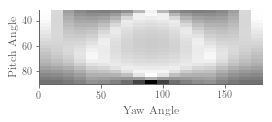

In [51]:
plt.figure(figsize=(4,3))
ax = plt.subplot(111)
ax.grid(False)

start_pitch, end_pitch = camera_pitches[0], camera_pitches[-1]
start_yaw, end_yaw = camera_yaws[0], camera_yaws[-1]
pitch_range, yaw_range = end_pitch - start_pitch, end_yaw - start_yaw
plt.imshow(np.flip(scores, 0), extent=[start_yaw-180,end_yaw-180, end_pitch,start_pitch])

plt.xlabel("Yaw Angle")
plt.ylabel("Pitch Angle")
plt.gray()
if save:
    plt.savefig("pitch_yaw_0_curvature.png", bbox_inches='tight')
else:
    plt.show()


In [18]:
# get sorted indices
sorted_indices = np.array(np.unravel_index(np.argsort(scores, axis=None), scores.shape)).T
print(sorted_indices)


[[ 0  9]
 [ 0 10]
 [ 0  8]
 [ 0 11]
 [ 0  7]
 [ 0  0]
 [ 0 18]
 [ 0  1]
 [ 0 17]
 [ 0  2]
 [ 0 16]
 [ 1  0]
 [ 1 18]
 [20  5]
 [20 13]
 [ 1  1]
 [ 1 17]
 [20  4]
 [20 14]
 [ 0 12]
 [ 0  6]
 [20  6]
 [20 12]
 [ 0  3]
 [ 0 15]
 [ 1  2]
 [ 1 16]
 [ 2  0]
 [ 2 18]
 [20 15]
 [20  3]
 [ 2  1]
 [ 2 17]
 [ 0  5]
 [ 0 13]
 [19 14]
 [19  4]
 [20  7]
 [20 11]
 [19 13]
 [19  5]
 [ 1  3]
 [ 1 15]
 [ 0  4]
 [ 0 14]
 [ 2  2]
 [ 2 16]
 [19 15]
 [19  3]
 [ 3  0]
 [ 3 18]
 [ 1  7]
 [ 1 11]
 [ 3  1]
 [ 3 17]
 [ 1  6]
 [ 1 12]
 [19  6]
 [19 12]
 [ 1  8]
 [ 1 10]
 [18  4]
 [18 14]
 [ 1 13]
 [ 1  5]
 [20  2]
 [20 16]
 [ 2  3]
 [18 15]
 [18  3]
 [ 2 15]
 [ 3  2]
 [ 1  4]
 [ 3 16]
 [ 1 14]
 [18  5]
 [18 13]
 [ 4  0]
 [ 4 18]
 [19  2]
 [19 16]
 [ 4  1]
 [ 4 17]
 [17 14]
 [17  4]
 [17  3]
 [17 15]
 [ 3  3]
 [ 5  0]
 [18  2]
 [18 16]
 [ 5 18]
 [ 3 15]
 [ 4  2]
 [ 4 16]
 [ 2  5]
 [ 2 13]
 [17 13]
 [17  5]
 [ 2  4]
 [ 2 14]
 [18  6]
 [18 12]
 [ 1  9]
 [16  3]
 [16 15]
 [ 2  6]
 [ 2 12]
 [16 14]
 [16  4]
 [17  2]
 

Pitches: 
[ 31.  34.  37.  40.  43.  46.  49.  52.  55.  58.  61.  64.  67.  70.  73.
  76.  79.  82.  85.  88.  91.]
Yaws: 
[   0.   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.  110.
  120.  130.  140.  150.  160.  170.  180.]
Score: 4.2936 -- Pitch: 79.0, Yaw: 0.0 (index 16, 0)


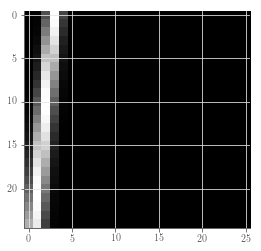

Score: 4.2936 -- Pitch: 79.0, Yaw: 180.0 (index 16, 18)


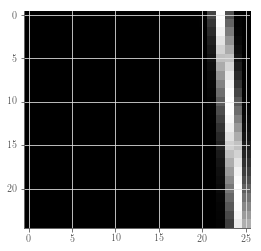

Score: 4.3020 -- Pitch: 91.0, Yaw: 90.0 (index 20, 9)


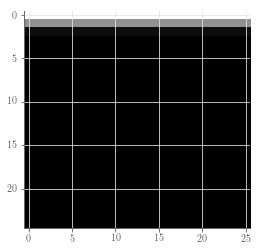

Score: 4.3057 -- Pitch: 40.0, Yaw: 80.0 (index 3, 8)


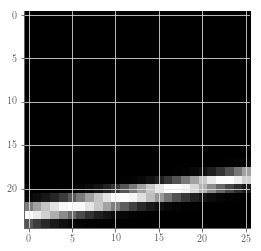

Score: 4.3057 -- Pitch: 40.0, Yaw: 100.0 (index 3, 10)


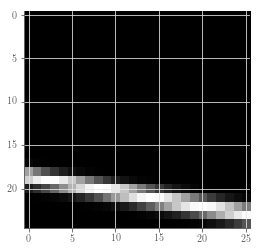

Score: 4.3114 -- Pitch: 40.0, Yaw: 90.0 (index 3, 9)


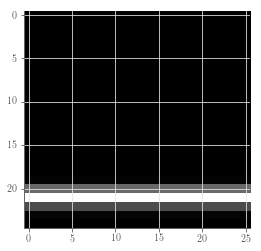

Score: 4.3396 -- Pitch: 55.0, Yaw: 40.0 (index 8, 4)


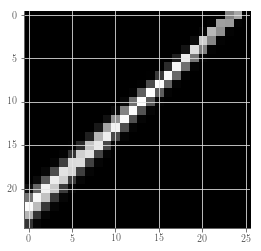

Score: 4.3396 -- Pitch: 55.0, Yaw: 140.0 (index 8, 14)


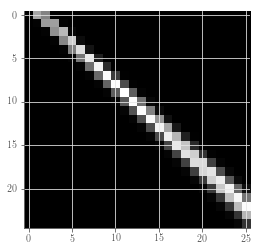

Score: 4.3552 -- Pitch: 52.0, Yaw: 40.0 (index 7, 4)


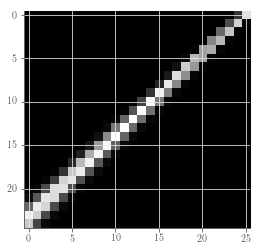

Score: 4.3552 -- Pitch: 52.0, Yaw: 140.0 (index 7, 14)


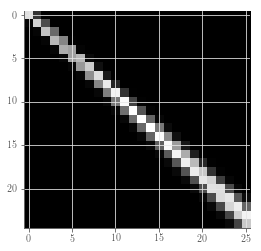

Score: 4.3694 -- Pitch: 82.0, Yaw: 0.0 (index 17, 0)


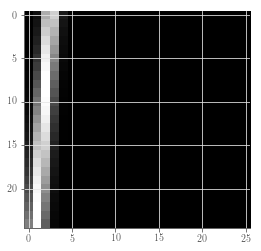

Score: 4.3694 -- Pitch: 82.0, Yaw: 180.0 (index 17, 18)


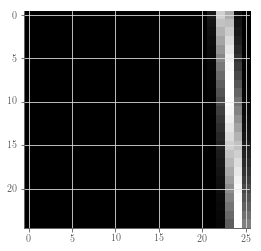

Score: 4.3792 -- Pitch: 88.0, Yaw: 90.0 (index 19, 9)


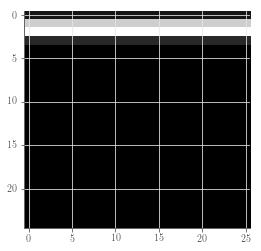

Score: 4.4254 -- Pitch: 85.0, Yaw: 0.0 (index 18, 0)


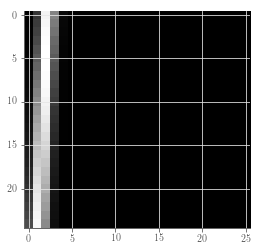

Score: 4.4254 -- Pitch: 85.0, Yaw: 180.0 (index 18, 18)


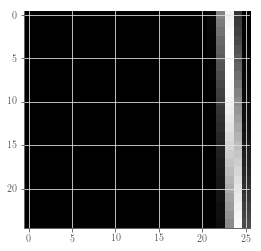

Score: 4.4566 -- Pitch: 88.0, Yaw: 0.0 (index 19, 0)


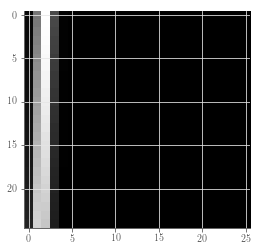

Score: 4.4566 -- Pitch: 88.0, Yaw: 180.0 (index 19, 18)


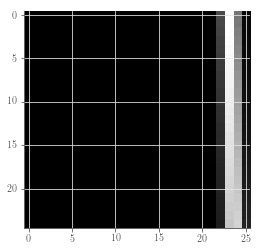

Score: 4.4605 -- Pitch: 91.0, Yaw: 0.0 (index 20, 0)


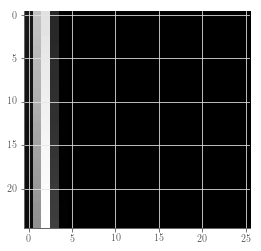

Score: 4.4605 -- Pitch: 91.0, Yaw: 180.0 (index 20, 18)


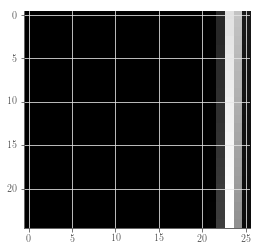

Score: 4.4844 -- Pitch: 37.0, Yaw: 90.0 (index 2, 9)


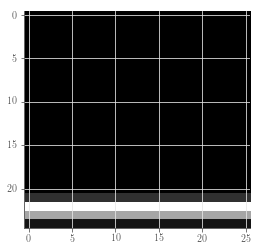

In [19]:
# look at the top 10 scores


print("Pitches: \n{0}".format(camera_pitches))
print("Yaws: \n{0}".format(camera_yaws))
for pitch_index, yaw_index in sorted_indices[-20:]:
    pitch, yaw = camera_pitches[pitch_index], camera_yaws[yaw_index]
    print("Score: {2:.4f} -- Pitch: {0}, Yaw: {1} (index {3}, {4})".format(pitch, yaw, scores[pitch_index, yaw_index], pitch_index, yaw_index))
    
    c = Camera(camera_position, pitch, yaw)
    c.set_resolution(25, 25)
    c.set_fov(*fov_deg)
    
    pixel_probabilities = c.get_pixel_probabilities_for_road(road)
    plt.imshow(np.flip(pixel_probabilities, 0))
    plt.gray()
    plt.show()


In [20]:
"""
pitch_index, yaw_index= 2, 9
pitch, yaw = camera_pitches[pitch_index], camera_yaws[yaw_index]
print("pitch, yaw: {0}, {1}, precomputed score: {2}".format(pitch, yaw, scores[pitch_index, yaw_index]))
c = Camera(camera_position, pitch, yaw)
c.set_resolution(25, 25)
c.set_fov(*fov_deg)
pixel_probabilities = c.get_pixel_probabilities_for_road(road)
error_bounds = error_radius_across_pixels(c)
target = (1.0/(1+error_bounds)) * pixel_probabilities
score = np.sum(target)
print("Score: {0}".format(score))
plt.imshow(np.flip(pixel_probabilities, 0))
plt.gray()
plt.show()
"""

'\npitch_index, yaw_index= 2, 9\npitch, yaw = camera_pitches[pitch_index], camera_yaws[yaw_index]\nprint("pitch, yaw: {0}, {1}, precomputed score: {2}".format(pitch, yaw, scores[pitch_index, yaw_index]))\nc = Camera(camera_position, pitch, yaw)\nc.set_resolution(25, 25)\nc.set_fov(*fov_deg)\npixel_probabilities = c.get_pixel_probabilities_for_road(road)\nerror_bounds = error_radius_across_pixels(c)\ntarget = (1.0/(1+error_bounds)) * pixel_probabilities\nscore = np.sum(target)\nprint("Score: {0}".format(score))\nplt.imshow(np.flip(pixel_probabilities, 0))\nplt.gray()\nplt.show()\n'

In [21]:
"""
pitch_index, yaw_index = 7, 14
pitch, yaw = camera_pitches[pitch_index], camera_yaws[yaw_index]
print("pitch, yaw: {0}, {1}, precomputed score: {2}".format(pitch, yaw, scores[pitch_index, yaw_index]))
c = Camera(camera_position, pitch, yaw)
c.set_resolution(100, 100)
c.set_fov(*fov_deg)
pixel_probabilities = c.get_pixel_probabilities_for_road(road)
print("Sum pixel probabilities: {0}".format(np.sum(pixel_probabilities)))
error_bounds = error_radius_across_pixels(c)
print("Sum error bounds: {0}".format(np.sum(error_bounds)))
target = (1.0/(1+error_bounds)) * pixel_probabilities
score = np.sum(target)
print("Score: {0}".format(score))
plt.imshow(np.flip(pixel_probabilities, 0))
plt.gray()
plt.show()
"""

'\npitch_index, yaw_index = 7, 14\npitch, yaw = camera_pitches[pitch_index], camera_yaws[yaw_index]\nprint("pitch, yaw: {0}, {1}, precomputed score: {2}".format(pitch, yaw, scores[pitch_index, yaw_index]))\nc = Camera(camera_position, pitch, yaw)\nc.set_resolution(100, 100)\nc.set_fov(*fov_deg)\npixel_probabilities = c.get_pixel_probabilities_for_road(road)\nprint("Sum pixel probabilities: {0}".format(np.sum(pixel_probabilities)))\nerror_bounds = error_radius_across_pixels(c)\nprint("Sum error bounds: {0}".format(np.sum(error_bounds)))\ntarget = (1.0/(1+error_bounds)) * pixel_probabilities\nscore = np.sum(target)\nprint("Score: {0}".format(score))\nplt.imshow(np.flip(pixel_probabilities, 0))\nplt.gray()\nplt.show()\n'

In [22]:
"""
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scores_flat = scores.ravel()
ps, ys = np.meshgrid(camera_pitches, camera_yaws)
ps_, ys_ = ps.ravel(), ys.ravel()
bottom = np.zeros_like(ps_)
width = ps[0, 1] - ps[0,0]
depth = ys[0,0] - ys[1,0]
print(ps_.shape, ys_.shape, scores.ravel().shape)
print(width, depth)
ax.bar3d(ps_, ys_, bottom, width, depth, scores.ravel(), shade=True)
plt.show()
"""

"\nfig = plt.figure()\nax = fig.add_subplot(111, projection='3d')\nscores_flat = scores.ravel()\nps, ys = np.meshgrid(camera_pitches, camera_yaws)\nps_, ys_ = ps.ravel(), ys.ravel()\nbottom = np.zeros_like(ps_)\nwidth = ps[0, 1] - ps[0,0]\ndepth = ys[0,0] - ys[1,0]\nprint(ps_.shape, ys_.shape, scores.ravel().shape)\nprint(width, depth)\nax.bar3d(ps_, ys_, bottom, width, depth, scores.ravel(), shade=True)\nplt.show()\n"

In [23]:
"""
c2 = Camera(camera_position, 55, 25)
c2.set_resolution(200,200)
pixel_probabilities = c2.get_pixel_probabilities_for_road(road)
pitch = 55
for y in camera_yaws:
    print(y)
    c = Camera(camera_position, pitch, y)
    c.set_resolution(50, 50)
    pixel_probabilities = c.get_pixel_probabilities_for_road(road)
    # flip the y axis for displaying as an image...
    
    plt.imshow(np.flip(pixel_probabilities, 0))
    plt.gray()
    plt.show()
"""

'\nc2 = Camera(camera_position, 55, 25)\nc2.set_resolution(200,200)\npixel_probabilities = c2.get_pixel_probabilities_for_road(road)\npitch = 55\nfor y in camera_yaws:\n    print(y)\n    c = Camera(camera_position, pitch, y)\n    c.set_resolution(50, 50)\n    pixel_probabilities = c.get_pixel_probabilities_for_road(road)\n    # flip the y axis for displaying as an image...\n    \n    plt.imshow(np.flip(pixel_probabilities, 0))\n    plt.gray()\n    plt.show()\n'

## Take into account Curvature
how to handle edge of roads? usually have an occlusion... 
* add a cylinder at the position the camera is located! => raytracer will intersect this

In [24]:
def plot_vector(axis, vec_start, vec_end):
    x,y,z =vec_start
    u,v,w = vec_end - vec_start
    axis.quiver(x,y,z,u,v,w)
def plot_points(axis, points):
    if points.shape[0] == 0:
        return
    axis.scatter(points[:, 0], points[:, 1], points[:, 2])

In [35]:
curvatures = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]
# curvatures = [0.1]
curvature_score_maps = []
# separate cell => abort and can save partial results

---- Curvature: 0.001 ----
Cylinder radius: 997.0
Road radius: 1000.0
Processing: pitch -- 31.0, yaw -- 180.0
Score: 2.3279372766
Processing: pitch -- 34.0, yaw -- 180.0
Score: 2.52606307033
Processing: pitch -- 37.0, yaw -- 180.0
Score: 2.70773452633
Processing: pitch -- 40.0, yaw -- 180.0
Score: 2.87658631753
Processing: pitch -- 43.0, yaw -- 180.0
Score: 3.03015859056
Processing: pitch -- 46.0, yaw -- 180.0
Score: 3.16884790905
Processing: pitch -- 49.0, yaw -- 180.0
Score: 3.29432396409
Processing: pitch -- 52.0, yaw -- 180.0
Score: 3.4090231847
Processing: pitch -- 55.0, yaw -- 180.0
Score: 3.51565850235
Processing: pitch -- 58.0, yaw -- 180.0
Score: 3.61689479534
Processing: pitch -- 61.0, yaw -- 180.0
Score: 3.71514249455
Processing: pitch -- 64.0, yaw -- 180.0
Score: 3.81241285723
Processing: pitch -- 67.0, yaw -- 180.0
Score: 3.91010346414
Processing: pitch -- 70.0, yaw -- 180.0
Score: 4.00869964157
Processing: pitch -- 73.0, yaw -- 180.0
Score: 4.10735683912
Processing: pitch

Score: 4.00718669007
Processing: pitch -- 55.0, yaw -- 240.0
Score: 3.95901297333
Processing: pitch -- 58.0, yaw -- 240.0
Score: 3.9331788271
Processing: pitch -- 61.0, yaw -- 240.0
Score: 3.92905349009
Processing: pitch -- 64.0, yaw -- 240.0
Score: 3.94660414962
Processing: pitch -- 67.0, yaw -- 240.0
Score: 3.98620347706
Processing: pitch -- 70.0, yaw -- 240.0
Score: 4.04872388863
Processing: pitch -- 73.0, yaw -- 240.0
Score: 4.13084431104
Processing: pitch -- 76.0, yaw -- 240.0
Score: 4.09718005385
Processing: pitch -- 79.0, yaw -- 240.0
Score: 3.8436983249
Processing: pitch -- 82.0, yaw -- 240.0
Score: 3.5386745559
Processing: pitch -- 85.0, yaw -- 240.0
Score: 3.20525835984
Processing: pitch -- 88.0, yaw -- 240.0
Score: 2.83975339727
Processing: pitch -- 91.0, yaw -- 240.0
Score: 2.43742088576
Processing: pitch -- 31.0, yaw -- 250.0
Score: 2.09799607175
Processing: pitch -- 34.0, yaw -- 250.0
Score: 2.77432679153
Processing: pitch -- 37.0, yaw -- 250.0
Score: 3.42978225421
Proces

Score: 3.8436983249
Processing: pitch -- 82.0, yaw -- 300.0
Score: 3.5386745559
Processing: pitch -- 85.0, yaw -- 300.0
Score: 3.20525835984
Processing: pitch -- 88.0, yaw -- 300.0
Score: 2.83975339727
Processing: pitch -- 91.0, yaw -- 300.0
Score: 2.43742088576
Processing: pitch -- 31.0, yaw -- 310.0
Score: 2.59864855888
Processing: pitch -- 34.0, yaw -- 310.0
Score: 2.89567316469
Processing: pitch -- 37.0, yaw -- 310.0
Score: 3.19570768459
Processing: pitch -- 40.0, yaw -- 310.0
Score: 3.49951338393
Processing: pitch -- 43.0, yaw -- 310.0
Score: 3.80608511441
Processing: pitch -- 46.0, yaw -- 310.0
Score: 4.07857205617
Processing: pitch -- 49.0, yaw -- 310.0
Score: 4.19815789689
Processing: pitch -- 52.0, yaw -- 310.0
Score: 4.18567538423
Processing: pitch -- 55.0, yaw -- 310.0
Score: 4.16139340082
Processing: pitch -- 58.0, yaw -- 310.0
Score: 4.1580403158
Processing: pitch -- 61.0, yaw -- 310.0
Score: 4.17758237651
Processing: pitch -- 64.0, yaw -- 310.0
Score: 4.2161594855
Process

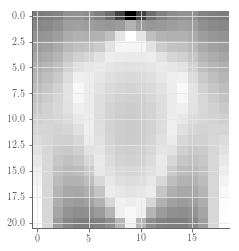

---- Curvature: 0.005 ----
Cylinder radius: 197.0
Road radius: 200.0
Processing: pitch -- 31.0, yaw -- 180.0
Score: 2.32109687514
Processing: pitch -- 34.0, yaw -- 180.0
Score: 2.52766505752
Processing: pitch -- 37.0, yaw -- 180.0
Score: 2.70926522632
Processing: pitch -- 40.0, yaw -- 180.0
Score: 2.87638131177
Processing: pitch -- 43.0, yaw -- 180.0
Score: 3.02879222505
Processing: pitch -- 46.0, yaw -- 180.0
Score: 3.16690949745
Processing: pitch -- 49.0, yaw -- 180.0
Score: 3.29236093517
Processing: pitch -- 52.0, yaw -- 180.0
Score: 3.40742690997
Processing: pitch -- 55.0, yaw -- 180.0
Score: 3.51464039418
Processing: pitch -- 58.0, yaw -- 180.0
Score: 3.61646523394
Processing: pitch -- 61.0, yaw -- 180.0
Score: 3.71514430148
Processing: pitch -- 64.0, yaw -- 180.0
Score: 3.81252928682
Processing: pitch -- 67.0, yaw -- 180.0
Score: 3.90990817556
Processing: pitch -- 70.0, yaw -- 180.0
Score: 4.00773793989
Processing: pitch -- 73.0, yaw -- 180.0
Score: 4.10525185648
Processing: pitc

Score: 4.01926365526
Processing: pitch -- 55.0, yaw -- 240.0
Score: 3.97130392527
Processing: pitch -- 58.0, yaw -- 240.0
Score: 3.94573561338
Processing: pitch -- 61.0, yaw -- 240.0
Score: 3.94194867136
Processing: pitch -- 64.0, yaw -- 240.0
Score: 3.95990473543
Processing: pitch -- 67.0, yaw -- 240.0
Score: 3.99998739109
Processing: pitch -- 70.0, yaw -- 240.0
Score: 4.06306190518
Processing: pitch -- 73.0, yaw -- 240.0
Score: 4.1374998606
Processing: pitch -- 76.0, yaw -- 240.0
Score: 4.05496921611
Processing: pitch -- 79.0, yaw -- 240.0
Score: 3.79980740102
Processing: pitch -- 82.0, yaw -- 240.0
Score: 3.50628184879
Processing: pitch -- 85.0, yaw -- 240.0
Score: 3.18279355587
Processing: pitch -- 88.0, yaw -- 240.0
Score: 2.82527247888
Processing: pitch -- 91.0, yaw -- 240.0
Score: 2.42875194396
Processing: pitch -- 31.0, yaw -- 250.0
Score: 2.11332988656
Processing: pitch -- 34.0, yaw -- 250.0
Score: 2.7822170972
Processing: pitch -- 37.0, yaw -- 250.0
Score: 3.44044724064
Proce

Score: 3.79980740102
Processing: pitch -- 82.0, yaw -- 300.0
Score: 3.50628184879
Processing: pitch -- 85.0, yaw -- 300.0
Score: 3.18279355587
Processing: pitch -- 88.0, yaw -- 300.0
Score: 2.82527247888
Processing: pitch -- 91.0, yaw -- 300.0
Score: 2.42875194396
Processing: pitch -- 31.0, yaw -- 310.0
Score: 2.62866543835
Processing: pitch -- 34.0, yaw -- 310.0
Score: 2.92313025073
Processing: pitch -- 37.0, yaw -- 310.0
Score: 3.22204331634
Processing: pitch -- 40.0, yaw -- 310.0
Score: 3.52605899177
Processing: pitch -- 43.0, yaw -- 310.0
Score: 3.83401180327
Processing: pitch -- 46.0, yaw -- 310.0
Score: 4.107525639
Processing: pitch -- 49.0, yaw -- 310.0
Score: 4.22549656219
Processing: pitch -- 52.0, yaw -- 310.0
Score: 4.21210808047
Processing: pitch -- 55.0, yaw -- 310.0
Score: 4.18828598135
Processing: pitch -- 58.0, yaw -- 310.0
Score: 4.18569123384
Processing: pitch -- 61.0, yaw -- 310.0
Score: 4.20607394347
Processing: pitch -- 64.0, yaw -- 310.0
Score: 4.22613259005
Proce

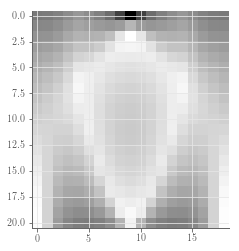

---- Curvature: 0.01 ----
Cylinder radius: 97.0
Road radius: 100.0
Processing: pitch -- 31.0, yaw -- 180.0
Score: 2.31426962856
Processing: pitch -- 34.0, yaw -- 180.0
Score: 2.52065873386
Processing: pitch -- 37.0, yaw -- 180.0
Score: 2.71810732569
Processing: pitch -- 40.0, yaw -- 180.0
Score: 2.88138526313
Processing: pitch -- 43.0, yaw -- 180.0
Score: 3.03130735439
Processing: pitch -- 46.0, yaw -- 180.0
Score: 3.16800857718
Processing: pitch -- 49.0, yaw -- 180.0
Score: 3.29288975902
Processing: pitch -- 52.0, yaw -- 180.0
Score: 3.40798294529
Processing: pitch -- 55.0, yaw -- 180.0
Score: 3.51554073523
Processing: pitch -- 58.0, yaw -- 180.0
Score: 3.61778496846
Processing: pitch -- 61.0, yaw -- 180.0
Score: 3.71671699047
Processing: pitch -- 64.0, yaw -- 180.0
Score: 3.81399648346
Processing: pitch -- 67.0, yaw -- 180.0
Score: 3.91077559816
Processing: pitch -- 70.0, yaw -- 180.0
Score: 4.00745372389
Processing: pitch -- 73.0, yaw -- 180.0
Score: 4.10335366489
Processing: pitch 

Score: 4.03662160298
Processing: pitch -- 55.0, yaw -- 240.0
Score: 3.98888510986
Processing: pitch -- 58.0, yaw -- 240.0
Score: 3.96360882715
Processing: pitch -- 61.0, yaw -- 240.0
Score: 3.96020849639
Processing: pitch -- 64.0, yaw -- 240.0
Score: 3.97863770938
Processing: pitch -- 67.0, yaw -- 240.0
Score: 4.01929670645
Processing: pitch -- 70.0, yaw -- 240.0
Score: 4.08287777564
Processing: pitch -- 73.0, yaw -- 240.0
Score: 4.13486582752
Processing: pitch -- 76.0, yaw -- 240.0
Score: 3.99814064527
Processing: pitch -- 79.0, yaw -- 240.0
Score: 3.74886721934
Processing: pitch -- 82.0, yaw -- 240.0
Score: 3.46823064232
Processing: pitch -- 85.0, yaw -- 240.0
Score: 3.1560317145
Processing: pitch -- 88.0, yaw -- 240.0
Score: 2.8077994896
Processing: pitch -- 91.0, yaw -- 240.0
Score: 2.41818999731
Processing: pitch -- 31.0, yaw -- 250.0
Score: 2.13303676666
Processing: pitch -- 34.0, yaw -- 250.0
Score: 2.79304473503
Processing: pitch -- 37.0, yaw -- 250.0
Score: 3.45491906798
Proce

Score: 3.74886721934
Processing: pitch -- 82.0, yaw -- 300.0
Score: 3.46823064232
Processing: pitch -- 85.0, yaw -- 300.0
Score: 3.1560317145
Processing: pitch -- 88.0, yaw -- 300.0
Score: 2.8077994896
Processing: pitch -- 91.0, yaw -- 300.0
Score: 2.41818999731
Processing: pitch -- 31.0, yaw -- 310.0
Score: 2.6761630052
Processing: pitch -- 34.0, yaw -- 310.0
Score: 2.96699177413
Processing: pitch -- 37.0, yaw -- 310.0
Score: 3.26404252954
Processing: pitch -- 40.0, yaw -- 310.0
Score: 3.56784086626
Processing: pitch -- 43.0, yaw -- 310.0
Score: 3.87708739774
Processing: pitch -- 46.0, yaw -- 310.0
Score: 4.15145063326
Processing: pitch -- 49.0, yaw -- 310.0
Score: 4.26700730517
Processing: pitch -- 52.0, yaw -- 310.0
Score: 4.25221031772
Processing: pitch -- 55.0, yaw -- 310.0
Score: 4.22869571417
Processing: pitch -- 58.0, yaw -- 310.0
Score: 4.22680086237
Processing: pitch -- 61.0, yaw -- 310.0
Score: 4.24401500428
Processing: pitch -- 64.0, yaw -- 310.0
Score: 4.2012289693
Process

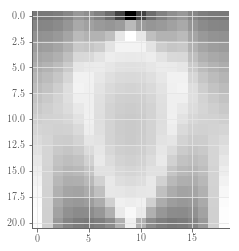

---- Curvature: 0.05 ----
Cylinder radius: 17.0
Road radius: 20.0
Processing: pitch -- 31.0, yaw -- 180.0
Score: 2.0758656488
Processing: pitch -- 34.0, yaw -- 180.0
Score: 2.24793137793
Processing: pitch -- 37.0, yaw -- 180.0
Score: 2.42085443034
Processing: pitch -- 40.0, yaw -- 180.0
Score: 2.59518482586
Processing: pitch -- 43.0, yaw -- 180.0
Score: 2.77160472027
Processing: pitch -- 46.0, yaw -- 180.0
Score: 2.95080980711
Processing: pitch -- 49.0, yaw -- 180.0
Score: 3.1334150593
Processing: pitch -- 52.0, yaw -- 180.0
Score: 3.31979063023
Processing: pitch -- 55.0, yaw -- 180.0
Score: 3.50929408731
Processing: pitch -- 58.0, yaw -- 180.0
Score: 3.67520866533
Processing: pitch -- 61.0, yaw -- 180.0
Score: 3.78814812078
Processing: pitch -- 64.0, yaw -- 180.0
Score: 3.87836036048
Processing: pitch -- 67.0, yaw -- 180.0
Score: 3.96100765848
Processing: pitch -- 70.0, yaw -- 180.0
Score: 4.03881844053
Processing: pitch -- 73.0, yaw -- 180.0
Score: 4.11137257152
Processing: pitch -- 

Score: 4.56007993573
Processing: pitch -- 55.0, yaw -- 240.0
Score: 4.41224111407
Processing: pitch -- 58.0, yaw -- 240.0
Score: 4.32464084065
Processing: pitch -- 61.0, yaw -- 240.0
Score: 4.25942540036
Processing: pitch -- 64.0, yaw -- 240.0
Score: 4.17932230824
Processing: pitch -- 67.0, yaw -- 240.0
Score: 4.07011084518
Processing: pitch -- 70.0, yaw -- 240.0
Score: 3.94170038724
Processing: pitch -- 73.0, yaw -- 240.0
Score: 3.79759719432
Processing: pitch -- 76.0, yaw -- 240.0
Score: 3.63448873035
Processing: pitch -- 79.0, yaw -- 240.0
Score: 3.44781643249
Processing: pitch -- 82.0, yaw -- 240.0
Score: 3.23229799346
Processing: pitch -- 85.0, yaw -- 240.0
Score: 2.98168388594
Processing: pitch -- 88.0, yaw -- 240.0
Score: 2.68842590572
Processing: pitch -- 91.0, yaw -- 240.0
Score: 2.34317907166
Processing: pitch -- 31.0, yaw -- 250.0
Score: 2.377882572
Processing: pitch -- 34.0, yaw -- 250.0
Score: 2.97396383688
Processing: pitch -- 37.0, yaw -- 250.0
Score: 3.66596250396
Proce

Score: 3.44781643249
Processing: pitch -- 82.0, yaw -- 300.0
Score: 3.23229799346
Processing: pitch -- 85.0, yaw -- 300.0
Score: 2.98168388594
Processing: pitch -- 88.0, yaw -- 300.0
Score: 2.68842590572
Processing: pitch -- 91.0, yaw -- 300.0
Score: 2.34317907166
Processing: pitch -- 31.0, yaw -- 310.0
Score: 2.69379669148
Processing: pitch -- 34.0, yaw -- 310.0
Score: 2.99573683024
Processing: pitch -- 37.0, yaw -- 310.0
Score: 3.31765548477
Processing: pitch -- 40.0, yaw -- 310.0
Score: 3.66318479835
Processing: pitch -- 43.0, yaw -- 310.0
Score: 4.03011379973
Processing: pitch -- 46.0, yaw -- 310.0
Score: 4.2805279073
Processing: pitch -- 49.0, yaw -- 310.0
Score: 4.33250411529
Processing: pitch -- 52.0, yaw -- 310.0
Score: 4.24800880992
Processing: pitch -- 55.0, yaw -- 310.0
Score: 4.1464892366
Processing: pitch -- 58.0, yaw -- 310.0
Score: 4.04598445501
Processing: pitch -- 61.0, yaw -- 310.0
Score: 3.94433025617
Processing: pitch -- 64.0, yaw -- 310.0
Score: 3.83885627477
Proce

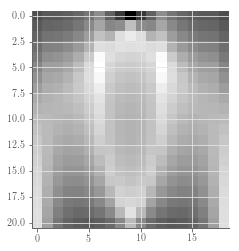

---- Curvature: 0.1 ----
Cylinder radius: 7.0
Road radius: 10.0
Processing: pitch -- 31.0, yaw -- 180.0
Score: 0.508712311329
Processing: pitch -- 34.0, yaw -- 180.0
Score: 0.774767821531
Processing: pitch -- 37.0, yaw -- 180.0
Score: 1.05649304811
Processing: pitch -- 40.0, yaw -- 180.0
Score: 1.33377935677
Processing: pitch -- 43.0, yaw -- 180.0
Score: 1.59607167399
Processing: pitch -- 46.0, yaw -- 180.0
Score: 1.84007937029
Processing: pitch -- 49.0, yaw -- 180.0
Score: 2.06645477558
Processing: pitch -- 52.0, yaw -- 180.0
Score: 2.27736398402
Processing: pitch -- 55.0, yaw -- 180.0
Score: 2.47511579296
Processing: pitch -- 58.0, yaw -- 180.0
Score: 2.66150154246
Processing: pitch -- 61.0, yaw -- 180.0
Score: 2.83777292044
Processing: pitch -- 64.0, yaw -- 180.0
Score: 3.00449721423
Processing: pitch -- 67.0, yaw -- 180.0
Score: 3.16169315417
Processing: pitch -- 70.0, yaw -- 180.0
Score: 3.30892060134
Processing: pitch -- 73.0, yaw -- 180.0
Score: 3.44527989978
Processing: pitch -

Score: 4.24197498951
Processing: pitch -- 55.0, yaw -- 240.0
Score: 4.12756593199
Processing: pitch -- 58.0, yaw -- 240.0
Score: 4.02314599543
Processing: pitch -- 61.0, yaw -- 240.0
Score: 3.92360530614
Processing: pitch -- 64.0, yaw -- 240.0
Score: 3.8249404994
Processing: pitch -- 67.0, yaw -- 240.0
Score: 3.72349746537
Processing: pitch -- 70.0, yaw -- 240.0
Score: 3.61568010073
Processing: pitch -- 73.0, yaw -- 240.0
Score: 3.49770327425
Processing: pitch -- 76.0, yaw -- 240.0
Score: 3.36533769954
Processing: pitch -- 79.0, yaw -- 240.0
Score: 3.21368019506
Processing: pitch -- 82.0, yaw -- 240.0
Score: 3.0368071574
Processing: pitch -- 85.0, yaw -- 240.0
Score: 2.82726778516
Processing: pitch -- 88.0, yaw -- 240.0
Score: 2.57536889328
Processing: pitch -- 91.0, yaw -- 240.0
Score: 2.26799761236
Processing: pitch -- 31.0, yaw -- 250.0
Score: 2.94151839165
Processing: pitch -- 34.0, yaw -- 250.0
Score: 3.49050975091
Processing: pitch -- 37.0, yaw -- 250.0
Score: 4.27621747382
Proce

Score: 3.21368019506
Processing: pitch -- 82.0, yaw -- 300.0
Score: 3.0368071574
Processing: pitch -- 85.0, yaw -- 300.0
Score: 2.82726778516
Processing: pitch -- 88.0, yaw -- 300.0
Score: 2.57536889328
Processing: pitch -- 91.0, yaw -- 300.0
Score: 2.26799761236
Processing: pitch -- 31.0, yaw -- 310.0
Score: 2.39332545556
Processing: pitch -- 34.0, yaw -- 310.0
Score: 2.67735879462
Processing: pitch -- 37.0, yaw -- 310.0
Score: 2.98912339448
Processing: pitch -- 40.0, yaw -- 310.0
Score: 3.33360489435
Processing: pitch -- 43.0, yaw -- 310.0
Score: 3.71785925529
Processing: pitch -- 46.0, yaw -- 310.0
Score: 4.04700235486
Processing: pitch -- 49.0, yaw -- 310.0
Score: 4.13033968617
Processing: pitch -- 52.0, yaw -- 310.0
Score: 4.00707340238
Processing: pitch -- 55.0, yaw -- 310.0
Score: 3.8928094385
Processing: pitch -- 58.0, yaw -- 310.0
Score: 3.78824711604
Processing: pitch -- 61.0, yaw -- 310.0
Score: 3.68806530934
Processing: pitch -- 64.0, yaw -- 310.0
Score: 3.58854698289
Proce

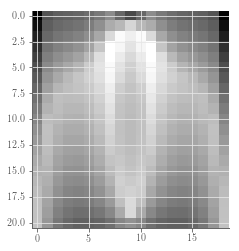

---- Curvature: 0.2 ----
Cylinder radius: 2.0
Road radius: 5.0
Processing: pitch -- 31.0, yaw -- 180.0
Score: 0.00016360486111
Processing: pitch -- 34.0, yaw -- 180.0
Score: 0.00236152216188
Processing: pitch -- 37.0, yaw -- 180.0
Score: 0.0159336480986
Processing: pitch -- 40.0, yaw -- 180.0
Score: 0.0632051960822
Processing: pitch -- 43.0, yaw -- 180.0
Score: 0.17215224899
Processing: pitch -- 46.0, yaw -- 180.0
Score: 0.358001378304
Processing: pitch -- 49.0, yaw -- 180.0
Score: 0.612220735965
Processing: pitch -- 52.0, yaw -- 180.0
Score: 0.908076818589
Processing: pitch -- 55.0, yaw -- 180.0
Score: 1.21470976176
Processing: pitch -- 58.0, yaw -- 180.0
Score: 1.50866814399
Processing: pitch -- 61.0, yaw -- 180.0
Score: 1.77695199432
Processing: pitch -- 64.0, yaw -- 180.0
Score: 2.01466755561
Processing: pitch -- 67.0, yaw -- 180.0
Score: 2.22115302321
Processing: pitch -- 70.0, yaw -- 180.0
Score: 2.39687938862
Processing: pitch -- 73.0, yaw -- 180.0
Score: 2.54181585017
Processin

Score: 3.95475582021
Processing: pitch -- 55.0, yaw -- 240.0
Score: 3.97097711137
Processing: pitch -- 58.0, yaw -- 240.0
Score: 3.82095961626
Processing: pitch -- 61.0, yaw -- 240.0
Score: 3.64485567848
Processing: pitch -- 64.0, yaw -- 240.0
Score: 3.51637632553
Processing: pitch -- 67.0, yaw -- 240.0
Score: 3.40327750354
Processing: pitch -- 70.0, yaw -- 240.0
Score: 3.29527549075
Processing: pitch -- 73.0, yaw -- 240.0
Score: 3.18614048767
Processing: pitch -- 76.0, yaw -- 240.0
Score: 3.07068698809
Processing: pitch -- 79.0, yaw -- 240.0
Score: 2.94359247922
Processing: pitch -- 82.0, yaw -- 240.0
Score: 2.79864783755
Processing: pitch -- 85.0, yaw -- 240.0
Score: 2.62791497368
Processing: pitch -- 88.0, yaw -- 240.0
Score: 2.4203811582
Processing: pitch -- 91.0, yaw -- 240.0
Score: 2.15945456242
Processing: pitch -- 31.0, yaw -- 250.0
Score: 2.3977945755
Processing: pitch -- 34.0, yaw -- 250.0
Score: 2.93806697207
Processing: pitch -- 37.0, yaw -- 250.0
Score: 3.97335628191
Proce

Score: 2.94359247922
Processing: pitch -- 82.0, yaw -- 300.0
Score: 2.79864783755
Processing: pitch -- 85.0, yaw -- 300.0
Score: 2.62791497368
Processing: pitch -- 88.0, yaw -- 300.0
Score: 2.4203811582
Processing: pitch -- 91.0, yaw -- 300.0
Score: 2.15945456242
Processing: pitch -- 31.0, yaw -- 310.0
Score: 2.15700147008
Processing: pitch -- 34.0, yaw -- 310.0
Score: 2.41528410534
Processing: pitch -- 37.0, yaw -- 310.0
Score: 2.70869482748
Processing: pitch -- 40.0, yaw -- 310.0
Score: 3.05386748501
Processing: pitch -- 43.0, yaw -- 310.0
Score: 3.46645408763
Processing: pitch -- 46.0, yaw -- 310.0
Score: 3.78290333578
Processing: pitch -- 49.0, yaw -- 310.0
Score: 3.84092165204
Processing: pitch -- 52.0, yaw -- 310.0
Score: 3.83793262169
Processing: pitch -- 55.0, yaw -- 310.0
Score: 3.86256069355
Processing: pitch -- 58.0, yaw -- 310.0
Score: 3.86443320344
Processing: pitch -- 61.0, yaw -- 310.0
Score: 3.54902544954
Processing: pitch -- 64.0, yaw -- 310.0
Score: 3.39312324804
Proc

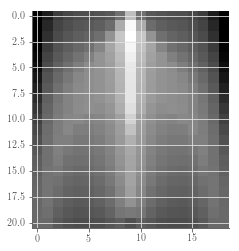

---- Curvature: 0.3 ----
Cylinder radius: 0.333333333333
Road radius: 3.33333333333
Processing: pitch -- 31.0, yaw -- 180.0
Score: 5.3726827832e-09
Processing: pitch -- 34.0, yaw -- 180.0
Score: 1.96434610227e-06
Processing: pitch -- 37.0, yaw -- 180.0
Score: 0.000127623320704
Processing: pitch -- 40.0, yaw -- 180.0
Score: 0.00239578908229
Processing: pitch -- 43.0, yaw -- 180.0
Score: 0.0186487672784
Processing: pitch -- 46.0, yaw -- 180.0
Score: 0.0783405695355
Processing: pitch -- 49.0, yaw -- 180.0
Score: 0.214263629843
Processing: pitch -- 52.0, yaw -- 180.0
Score: 0.434895623711
Processing: pitch -- 55.0, yaw -- 180.0
Score: 0.717192140533
Processing: pitch -- 58.0, yaw -- 180.0
Score: 1.02308212578
Processing: pitch -- 61.0, yaw -- 180.0
Score: 1.31931498823
Processing: pitch -- 64.0, yaw -- 180.0
Score: 1.5852633483
Processing: pitch -- 67.0, yaw -- 180.0
Score: 1.81070723668
Processing: pitch -- 70.0, yaw -- 180.0
Score: 1.99076958032
Processing: pitch -- 73.0, yaw -- 180.0
Sc

Score: 3.8238652249
Processing: pitch -- 55.0, yaw -- 240.0
Score: 3.81724275345
Processing: pitch -- 58.0, yaw -- 240.0
Score: 3.8321275894
Processing: pitch -- 61.0, yaw -- 240.0
Score: 3.8790119199
Processing: pitch -- 64.0, yaw -- 240.0
Score: 3.80361091189
Processing: pitch -- 67.0, yaw -- 240.0
Score: 3.34540740427
Processing: pitch -- 70.0, yaw -- 240.0
Score: 3.18359801474
Processing: pitch -- 73.0, yaw -- 240.0
Score: 3.05142637801
Processing: pitch -- 76.0, yaw -- 240.0
Score: 2.92734122012
Processing: pitch -- 79.0, yaw -- 240.0
Score: 2.80111902882
Processing: pitch -- 82.0, yaw -- 240.0
Score: 2.66468186721
Processing: pitch -- 85.0, yaw -- 240.0
Score: 2.50927381272
Processing: pitch -- 88.0, yaw -- 240.0
Score: 2.32335216991
Processing: pitch -- 91.0, yaw -- 240.0
Score: 2.08905748934
Processing: pitch -- 31.0, yaw -- 250.0
Score: 2.543901013
Processing: pitch -- 34.0, yaw -- 250.0
Score: 3.1901216989
Processing: pitch -- 37.0, yaw -- 250.0
Score: 4.39947470504
Processin

Score: 2.80111902882
Processing: pitch -- 82.0, yaw -- 300.0
Score: 2.66468186721
Processing: pitch -- 85.0, yaw -- 300.0
Score: 2.50927381272
Processing: pitch -- 88.0, yaw -- 300.0
Score: 2.32335216991
Processing: pitch -- 91.0, yaw -- 300.0
Score: 2.08905748934
Processing: pitch -- 31.0, yaw -- 310.0
Score: 2.09580019418
Processing: pitch -- 34.0, yaw -- 310.0
Score: 2.33024012363
Processing: pitch -- 37.0, yaw -- 310.0
Score: 2.60581302062
Processing: pitch -- 40.0, yaw -- 310.0
Score: 2.95162663307
Processing: pitch -- 43.0, yaw -- 310.0
Score: 3.39412155746
Processing: pitch -- 46.0, yaw -- 310.0
Score: 3.67028740693
Processing: pitch -- 49.0, yaw -- 310.0
Score: 3.67002534843
Processing: pitch -- 52.0, yaw -- 310.0
Score: 3.64208449649
Processing: pitch -- 55.0, yaw -- 310.0
Score: 3.6356032592
Processing: pitch -- 58.0, yaw -- 310.0
Score: 3.65187091049
Processing: pitch -- 61.0, yaw -- 310.0
Score: 3.69174638259
Processing: pitch -- 64.0, yaw -- 310.0
Score: 3.75653637712
Proc

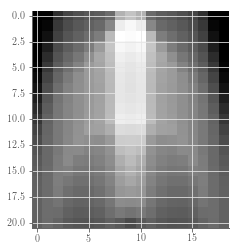

In [36]:
for curvature in curvatures:
    print("---- Curvature: {0} ----".format(curvature))
    camera_height = 6.0
#     resolution = (125, 125) # use same resolution for all
    fov_deg = (60.0, 60.0)
    yaw_range = 90 # degrees +- from center yaw position

    length = 2*np.pi/curvature # 1 full revolution

    path = Path()
    path.add_segment(curvature, length)
    road = Road(path=path, probability_distribution=road_prob_dist, width=3.0, side_offset=1.5)

    # place camera halfway along road
    allowed_positions_orientations = road.get_allowed_camera_positions_at_distance(length/2.0)
    lhs_pos, lhs_direction = allowed_positions_orientations[0]
    rhs_pos, rhs_direction = allowed_positions_orientations[1]

    #TODO figure out which one is LHS versus RHS for positive curvature...
    # ====> the first element (lhs here) is OUT ie. away from center of curvature
    # ====> LHS is good for first tests of outside
    
    camera_position = lhs_pos + np.array([0.0, 0.0, camera_height])
    camera_pitches = np.arange(31.0, 92.0, 3)

    # convert lhs_direction into a yaw facing the road perpendicularly
    center_yaw_rad = np.arccos(np.dot(np.array([1.0,0,0]), h.normalize(lhs_direction)))
    center_yaw_deg = np.rad2deg(center_yaw_rad) + 180 # TODO figure out automatically if the +180 is required
    camera_yaws = np.arange(center_yaw_deg - yaw_range, center_yaw_deg + yaw_range + 10, 10.0)
    
    # cylinder charactistics
    road_pt = road.path.get_point_at(length/2.0)
    road_normal = road.path.get_normal_at(length/2.0)
    road_radius = np.abs(1.0/road.path.get_curvature_at(length/2.0))
    cylinder_radius = np.abs(1.0/road.path.get_curvature_at(length/2.0)) 
    cylinder_radius -= road.halfwidth 
    cylinder_radius -= road.side_offset
    cylinder_center = road_pt + road_normal * road_radius
    cylinder_direction = np.array([0.0, 0.0, 1.0])
    
    x_unit, y_unit = np.array([1.0,0,0]), np.array([0.0, 1.0, 0.0])
    
    path_points = []
    for d in np.arange(0, length, 0.5):
        path_points.append(road.path.get_point_at(d))
    path_points = np.array(path_points)
    
    
    print("Cylinder radius: {0}".format(cylinder_radius))
    print("Road radius: {0}".format(1/road.path.get_curvature_at(length/2.0)))

    scores = np.zeros(shape=(camera_pitches.shape[0], camera_yaws.shape[0]))
    for j, yaw in enumerate(camera_yaws):
        for i, pitch in enumerate(camera_pitches):
            print("Processing: pitch -- {0}, yaw -- {1}".format(pitch, yaw))
            name = "pitch_{0}_yaw_{1}".format(pitch, yaw)
            camera = Camera(camera_position, pitch, yaw)
            camera.set_resolution(*resolution)
            camera.set_fov(*fov_deg)
            # set edge boundary for visual obstruction
            camera.attach_cylinder(cylinder_center, cylinder_direction, cylinder_radius)

            pixel_probabilities = camera.get_pixel_probabilities_for_road(road)

            # didn't want any pyplot stuff running
            # in case of leaking memory from open figures that I don't quite understand

#             plt.imshow(np.flip(pixel_probabilities, 0))
#             plt.gray()
#             plt.show()
            
#             fig = plt.figure()
#             ax = fig.add_subplot(111, projection='3d')
#             ax.view_init(elev=10., azim=0.0)
#             plot_vector(ax, camera.position, camera.position+camera.orientation_vector)
#             corners = camera.get_corners()
#             corners = np.array([x for x in corners if x is not None])
#             plot_points(ax, corners)
#             plot_points(ax, path_points)
#             plot_vector(ax, cylinder_center, cylinder_center + cylinder_direction)
#             plot_vector(ax, cylinder_center, cylinder_center+x_unit*cylinder_radius)
#             plot_vector(ax, cylinder_center, cylinder_center+y_unit*cylinder_radius)
#             plt.show()
            



            # calculate error radius at each pixel
            error_bounds = error_radius_across_pixels(camera)
    #         plt.imshow(error_bounds)
    #         plt.gray()
    #         plt.imsave(save_dir + name + "_error_bounds.png")

            target = (1.0/(1+(error_bounds/3.0)**2)) * pixel_probabilities
    #         plt.imshow(product)
    #         plt.gray()
    #         plt.imsave(save_dir + name + "_product.png")
            # take the sum => now have an expected value!

            score = np.sum(target)
            print("Score: {0}".format(score))
            scores[i, j] = score
    plt.imshow(scores)
    plt.gray()
    plt.show()
    curvature_score_maps.append(scores)

In [38]:
curvature_score_maps = np.array(curvature_score_maps)
np.save("V2_curved_roads_{0}x{1}_6m-4_two_stddev.npy".format(*resolution), curvature_score_maps)


In [ ]:
n_pitch = 21
n_yaw = 19
# if lost expensive computation again... can use printed strings to recover data
def string_to_scores(raw_str, n_pitch, n_yaw, pitch_axis_first=True):
    data = raw_str.split('\n')
    recovered = []
    for x in data:
        if 'Score' in x:
            recovered.append(float(x.split(':')[1].strip()))
    
    scores = np.array(recovered)
    if pitch_axis_first:
        # ie. the first axis printed was pitch
        scores = scores.reshape(n_pitch, n_yaw).T
    else:
        scores = scores.reshape(n_pitch, n_yaw)
    return scores

In [34]:
# --- resoume from saved maps ---
curvature_score_maps = np.load("V2_curved_roads_{0}x{1}_6m-4_two_stddev.npy".format(*(300,300)))


IOError: [Errno 2] No such file or directory: 'V2_curved_roads_300x300_6m-4_two_stddev.npy'

Curvature: 0.001, Radius: 1000.0, Circumference: 6283.18530718
Curvature: 0.005, Radius: 200.0, Circumference: 1256.63706144
Curvature: 0.01, Radius: 100.0, Circumference: 628.318530718
Curvature: 0.05, Radius: 20.0, Circumference: 125.663706144
Curvature: 0.1, Radius: 10.0, Circumference: 62.8318530718
Curvature: 0.2, Radius: 5.0, Circumference: 31.4159265359
Curvature: 0.3, Radius: 3.33333333333, Circumference: 20.9439510239


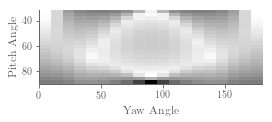

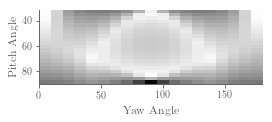

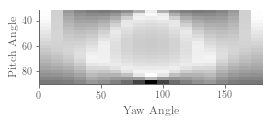

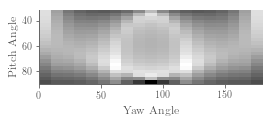

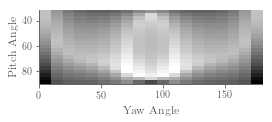

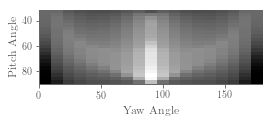

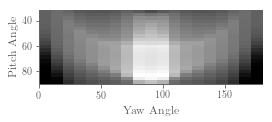

In [52]:
for i, score_map in enumerate(curvature_score_maps):
    print("Curvature: {0}, Radius: {1}, Circumference: {2}".format(curvatures[i], 1.0/curvatures[i], 2*np.pi/curvatures[i]))
    plt.figure(figsize=(4,3))
    ax = plt.subplot(111)
    ax.grid(False)
    start_pitch, end_pitch = camera_pitches[0], camera_pitches[-1]
    start_yaw, end_yaw = camera_yaws[0], camera_yaws[-1]
    pitch_range, yaw_range = end_pitch - start_pitch, end_yaw - start_yaw
    plt.imshow(np.flip(score_map, 0), extent=[start_yaw-180,end_yaw-180, end_pitch,start_pitch])
    plt.xlabel("Yaw Angle")
    plt.ylabel("Pitch Angle")
    plt.gray()
    if save:
        plt.savefig("pitch_yaw_at_radius_{0}.png".format(int(1.0/curvatures[i])) ,bbox_inches='tight')
    else:
        plt.show()
